### Họ và tên : Phạm Thành Công - 102200083
### Nguyễn Luật - 102190274
##                    ĐỀ TÀI: PHÂN ĐOẠN TÍN HIỆU GIỌNG NÓI VÀ KHOẢNG LẶNG DÙNG TIẾP CẬN NHẬN DẠNG

### Import các thư viện cần thiết

In [41]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from math import floor
import os

### Định nghĩa các đường dẫn đến file tín hiệu huấn luyện và kiểm thử

In [42]:
path_lab_training = 'D:/Hoc_Tap/Ki2_Nam3/KHDL/GK_KHDL/TinHieuHuanLuyen/lab'
path_wav_training = 'D:/Hoc_Tap/Ki2_Nam3/KHDL/GK_KHDL/TinHieuHuanLuyen/wav'
path_lab_test = 'D:/Hoc_Tap/Ki2_Nam3/KHDL/GK_KHDL/TinHieuKiemThu/lab'
path_wav_test = 'D:/Hoc_Tap/Ki2_Nam3/KHDL/GK_KHDL/TinHieuKiemThu/wav'
#data of test lab
data_lab_test = np.sort(np.array(os.listdir(path_lab_test)))
#data of test wav
data_wav_test = np.sort(np.array(os.listdir(path_wav_test)))

### Chia dữ liệu âm thành thành các frames với độ dài frame là 0.025s



In [43]:
def divide_frame(data, s_frame, n_frame): #f_d : do dai thoi gian moi khung
  tmp = 0
  frames = []
  for i in range(0, n_frame):
    frames.append(data[tmp : s_frame + tmp])
    tmp += s_frame
  return np.array(frames, dtype=float)


### Tính năng lượng STE tại các frame

In [44]:
def cal_STE(frames):
  ste = np.zeros(len(frames), dtype=float)
  for i in range(len(frames)):
    ste[i] = np.sum(frames[i] ** 2)
  ste = ste / np.abs(ste).max()
  return ste 


### Map STE ở từng frame phục vụ cho việc trực quan hóa dữ liệu


In [45]:
def cal_STE_sample(ste, s_frame, n_frame):
  ste_wave = np.zeros(n_frame * s_frame, dtype=float)
  l = 0
  for i in range(0, n_frame):
    ste_wave[l : l + s_frame] = ste[i]
    l += s_frame
  return ste_wave

### Lấy các mốc Speak và Silent từ file lab 


In [46]:
def get_landmark(filename, typeM):
    f = open(filename, 'r')
    list = []
    #lấy tất cả các dòng bỏ 2 dòng cuối file lab
    for x in f:
        list.append(str(x).split())
    list = list[:-2]
    np_list = np.array(list)

    time_sil = []
    
    #lấy các mốc time của silent
    for i in range(0, len(np_list)):
        if str(np_list[i,2]) == 'sil':
            time_sil.append(np_list[i, [0,1]])
    if typeM == 'sil':
        return time_sil
    else:
        #lấy các mốc time của speak
        time_speak = []
        for i in range(0, len(time_sil) -1):
            time_speak.append([time_sil[i][1], time_sil[i+1][0]])
    return time_speak

### Xuất histogram giữa giọng nói và khoảng lặng trong 1 file huấn luyện


Text(0.5, 1.0, 'Biểu đồ histogram giữa STE và giọng nói khoảng lặng')

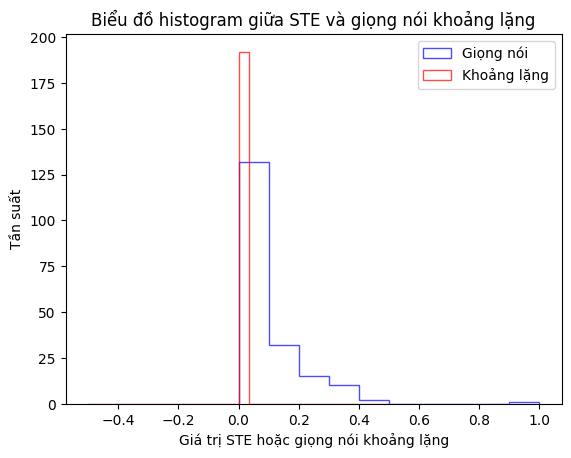

In [47]:
fs, data = wavfile.read('D:/Hoc_Tap/Ki2_Nam3/KHDL/GK_KHDL/TinHieuHuanLuyen/wav/phone_F2.wav')
np_data = np.array(data, dtype=float)
#chuẩn hóa dữ liệu
np_data = np_data / abs(np.abs(np_data).max())
s_frame = round(0.025 * fs)  # so luong mau tren moi frame
n_frame = floor(len(data) / s_frame) # so frame
frames_divide = divide_frame(data, s_frame, n_frame)
ste = cal_STE(frames_divide)

list_Evalute_Lab_Test = []
ste_sil = np.zeros(192)
ste_speak = np.zeros(192)
ste_speak_perform = np.zeros(192)
time_sil = get_landmark('D:/Hoc_Tap/Ki2_Nam3/KHDL/GK_KHDL/TinHieuHuanLuyen/lab/phone_F2.lab', 'sil')
np_time_sil = np.array(time_sil, dtype=float)
np_time_sil = np.round(np_time_sil / 0.025)
check_value = np.ones(192)
for i in range(len(np_time_sil)):
    check_value[int(np_time_sil[i][0]):int(np_time_sil[i][1])] = 0
for i in range(len(ste)):
    if check_value[i] == 1:
        ste_speak[i] = ste[i]
    else:
        ste_sil[i] = ste[i]
plt.hist(ste_speak, bins=10, alpha=0.7, label='Giọng nói',color='blue', histtype='step')
plt.hist(ste_speak_perform, bins=30, alpha=0.7, label='Khoảng lặng', color='red',  histtype='step')
plt.legend(loc='upper right')
plt.xlabel('Giá trị STE hoặc giọng nói khoảng lặng')
plt.ylabel('Tần suất')
plt.title('Biểu đồ histogram giữa STE và giọng nói khoảng lặng')

### Sử dụng thuật toán tìm kiếm nhị phân để tìm ngưỡng
+ Trong đó : f là phần năng lượng STE của vùng khoảng lặng
+              g là phần năng lượng STE của vùng tiếng nói

In [48]:
def binary_search(f, g):
  #Tìm T_max và T_min
  T_max = max(f.max(), g.max())
  T_min = min(f.max(), g.max())

  T = 0.5 * (T_min + T_max)

  #Tìm số lượng phần tử trên và dưới T
  i = len(f[f < T]) #Số lượng phần tử nhỏ hơn T của f
  p = len(g[g > T]) #Số lượng phần tử lớn hơn T của g

  j = -1
  q = -1
  N_f = len(f)
  N_g = len(g)

  while not (i == j and p == q):
    if np.sum(f[f > T] - T)/N_f - np.sum(T - g[g < T])/N_g > 0: #So sánh tỉ lệ phần tử bị mất với ngưỡng T của f và g
      T_min = T
    else:
      T_max = T

    T = 0.5 * (T_min + T_max)

    j = i;
    q = p;

    i = len(f[f < T])
    p = len(g[g > T])
  return T


### Tính toán ngưỡng theo label trong file huấn luyện

In [49]:
def find_threshold(filename, ste, f_d):

  #lấy các mốc time silent từ file lab
  time_sil = get_landmark(filename=filename, typeM='sil')
  np_ste_sil = np.array([])
  np_ste_speak = np.array([])
  
  #lấy năng lượng ste vùng silent
  for i in range(len(time_sil)):
    np_ste_sil = np.append(np_ste_sil, ste[round(float(time_sil[i][0]) / f_d) : round(float(time_sil[i][1]) / f_d)])

  #lấy các mốc time speak từ file lab
  time_speak = get_landmark(filename=filename, typeM='speak')
  #lấy năng lượng ste vùng speak
  for i in range(0, len(time_sil) -1):
    time_speak.append([time_sil[i][1], time_sil[i+1][0]])
    np_ste_speak = np.append(np_ste_speak, ste[round(float(time_sil[i][1]) / f_d) : round(float(time_sil[i+1][0]) / f_d)])
  
  return binary_search(np_ste_sil, np_ste_speak)

### Training tìm ngưỡng huấn luyện

In [50]:
def training_threshold(path_lab, path_wav):
  data_lab = np.sort(np.array(os.listdir(path_lab)))
  data_wav = np.sort(np.array(os.listdir(path_wav)))
  f_d = 0.025
  T = 0
  for i in range(0, len(data_wav)):
    fs, data = wavfile.read(path_wav + '/' + data_wav[i])
    np_data = np.array(data, dtype=float)
    np_data = np_data / abs(np.abs(np_data).max())
    s_frame = round(f_d * fs) # so luong mau tren moi frame
    n_frame = floor(len(data) / s_frame) # so frame
    frames_divide = divide_frame(data, s_frame, n_frame)
    ste = cal_STE(frames_divide)
    T += find_threshold(path_lab + '/' + data_lab[i], ste, f_d)
  return T / len(data_lab) 

### Trực quan hóa dữ liệu

In [51]:
def draw_data(np_data, ste_wave, t, t_ste_wave, id, index_time, fileName):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(22,10))


    ax1.plot(t, np_data, label='Data')
    ax1.plot(t_ste_wave, ste_wave, color='red', label='STE')
    ax1.legend(loc ='lower left', title=fileName)
    ax1.set_title('Đồ thị STE')

    ax2.plot(t, np_data, label='Data')
    ax2.plot(t_ste_wave, ste_wave, color='red', label='STE')
    ax2.vlines(id,ymin=-1,ymax=1,colors='blue',label='Biên phân đoạn thực hiện')
    ax2.legend(loc ='lower left', title=fileName)
    ax2.set_title('Kết quả phân đoạn thực hiện')


    ax3.plot(t, np_data, label='Data')
    ax3.plot(t_ste_wave, ste_wave, color='red', label='STE')
    ax3.vlines(id,ymin=-1,ymax=1,colors='blue',label='Biên phân đoạn thực hiện')
    ax3.vlines(index_time,ymin=-1,ymax=1,colors='red',label='Biên phân đoạn chuẩn')
    ax3.legend(loc ='lower left', title=fileName)
    ax3.set_title('Kết quả phân đoạn thực hiện')
    fig.show()

### Lấy mốc vị trí giữa speak và silent và trực quan hóa dữ liệu
+ Tín hiệu khoảng lặng (STE < Threshold)
+ Tín hiệu tiếng nói (STE > Threshold)
+ Lọc các khoảng lặng ảo < 0.3s


C:\Users\PC\AppData\Local\Temp\ipykernel_21544\3207038924.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(path_wav + '/' + data_wav[i])
C:\Users\PC\AppData\Local\Temp\ipykernel_21544\3880860831.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\PC\AppData\Local\Temp\ipykernel_21544\2332767589.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(path_wav_test + '/' + data_wav_test[index])


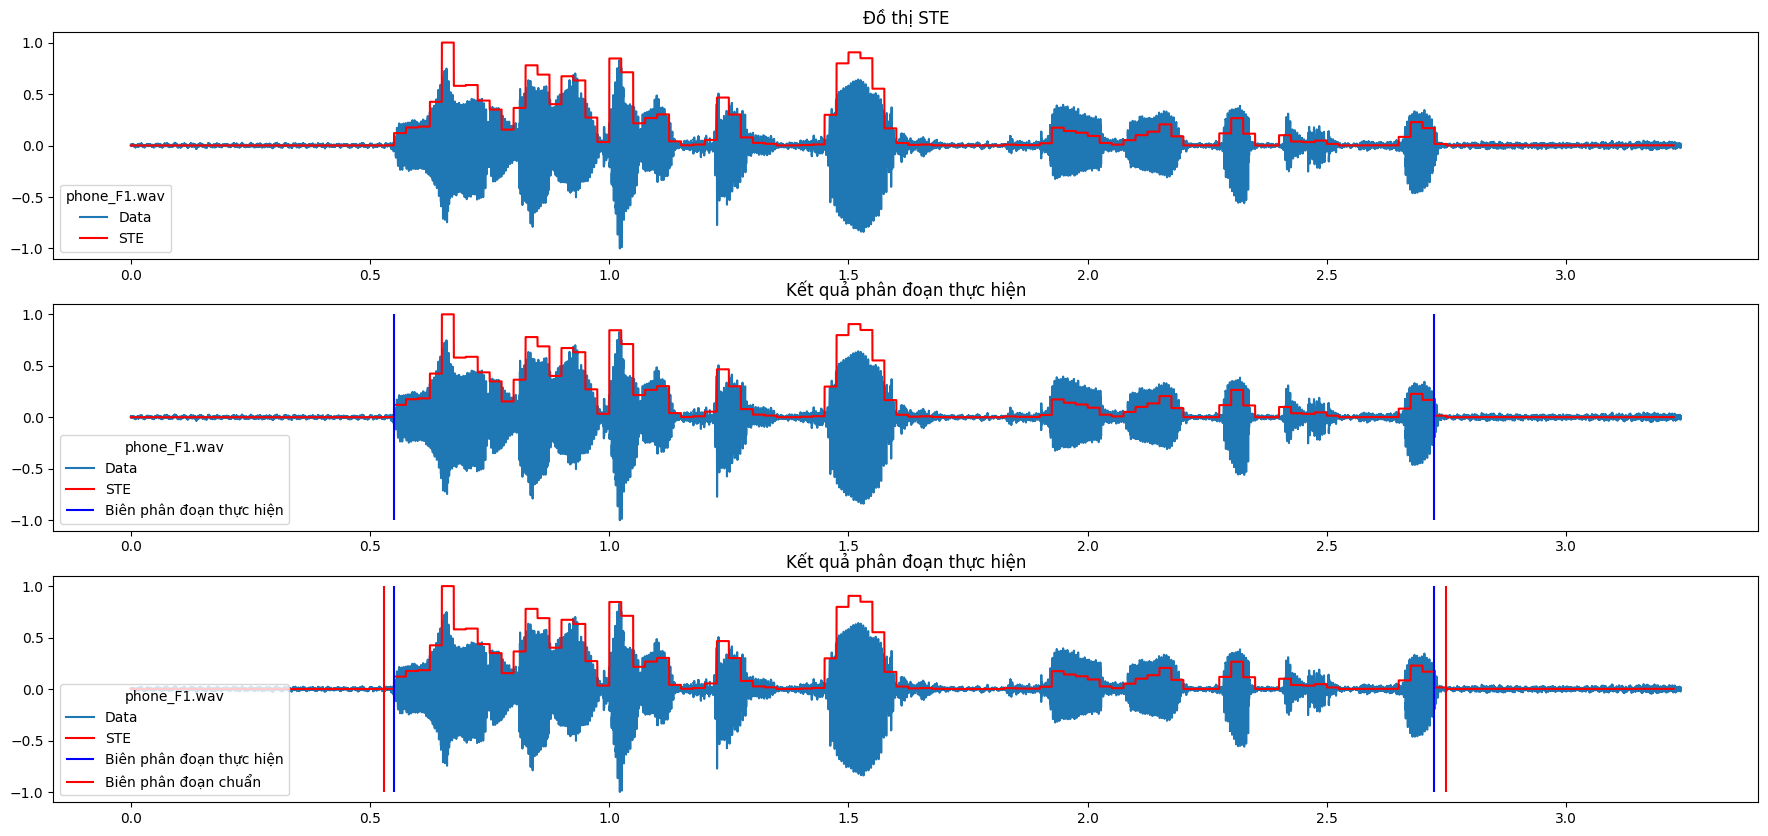

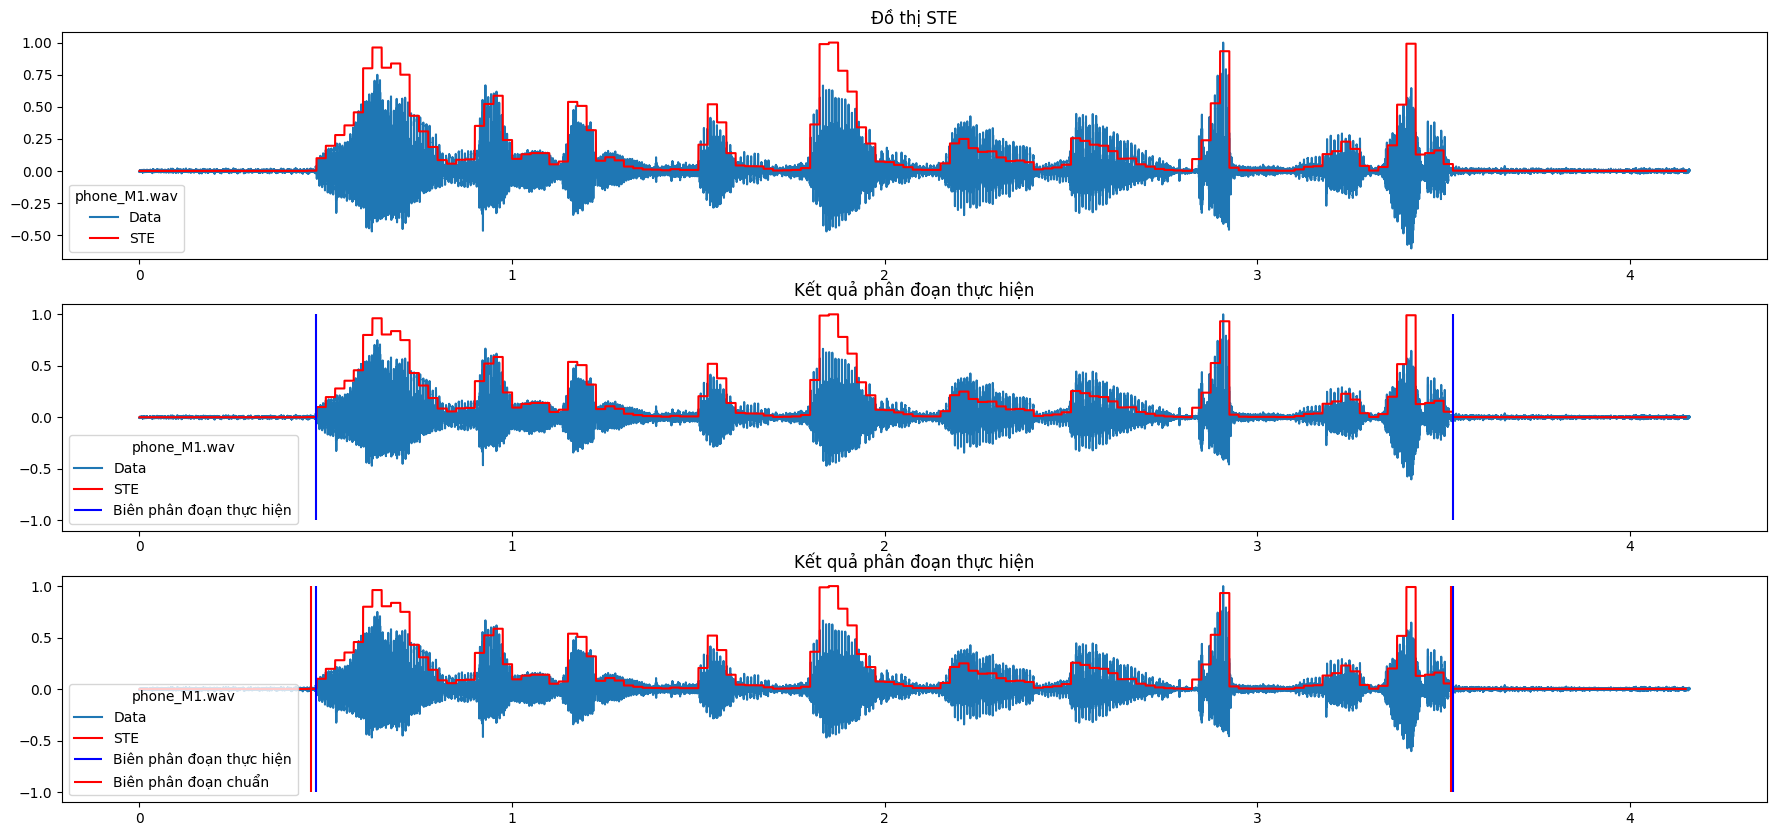

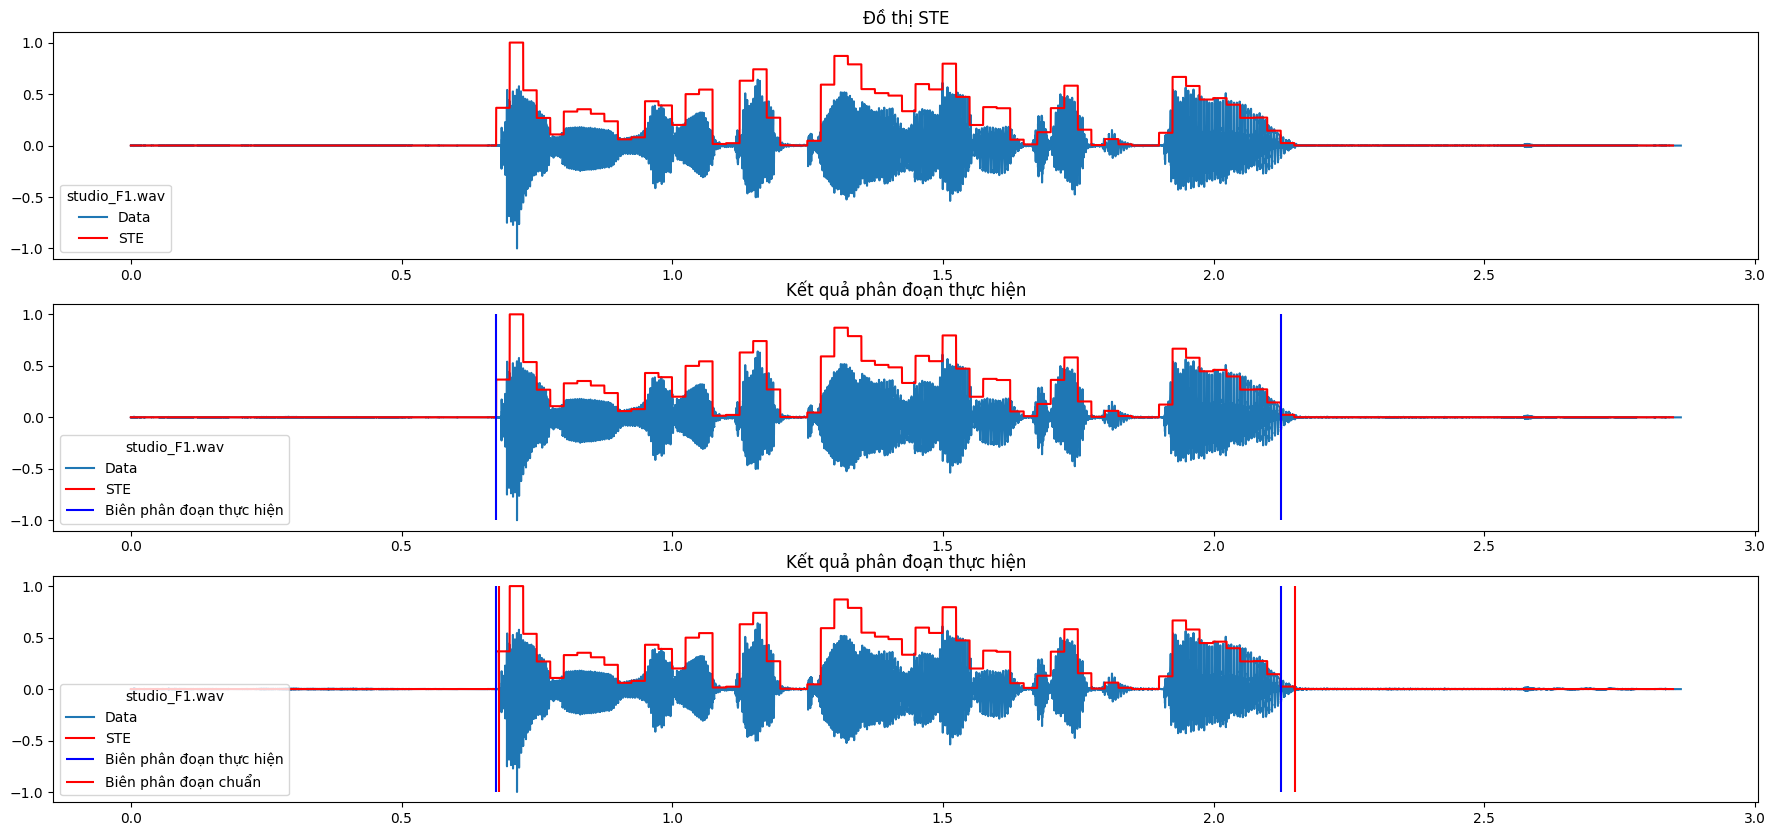

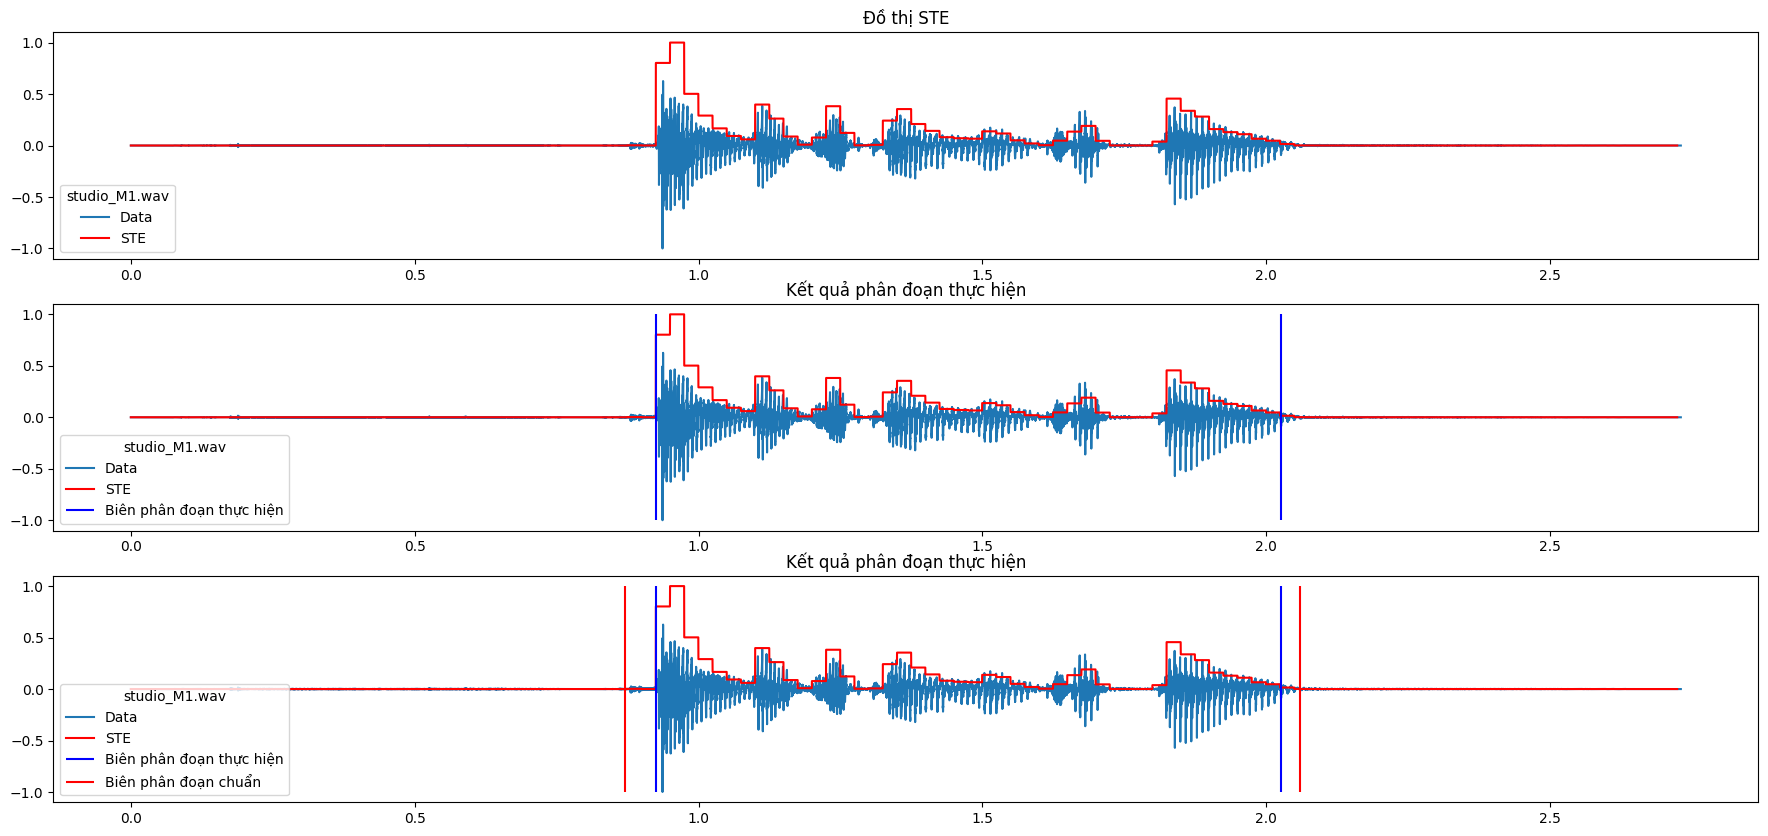

In [52]:
f_d = 0.025

#lấy ngưỡng huấn luyện
threshold = training_threshold(path_lab_training, path_wav_training)

#list check frame silent và speak phục vụ cho việc tính hiệu suất
list_Evalute_Per = []

for index in range(0, 4):
  fs, data = wavfile.read(path_wav_test + '/' + data_wav_test[index])
  fileName = data_wav_test[index]
  np_data = np.array(data, dtype=float)
  #chuẩn hóa dữ liệu
  np_data = np_data / abs(np.abs(np_data).max())
  s_frame = round(f_d * fs)  # so luong mau tren moi frame
  n_frame = floor(len(data) / s_frame) # so frame
  frames_divide = divide_frame(data, s_frame, n_frame)
  ste = cal_STE(frames_divide)
  vt_STE = np.array([], dtype=float)
  vt_STE = np.append(vt_STE, np.array(np.where(ste > threshold), dtype=float))

  #append mảng int phân loại speak, silent theo frame (1: speak, 0: silent)
  list_Evalute_Per.append(np.array((ste > threshold).astype(int)))

  id = np.array([], dtype=float)
  index_sil = np.array([],dtype=float)
  id = np.append(id, vt_STE[0])

  #Lấy các biên speak và silent thực hiện
  for i in range(1, len(vt_STE)):
    if i + 1 < len(vt_STE):
      if (f_d * vt_STE[i+1] - f_d * vt_STE[i]) > 0.3:
        id = np.append(id, vt_STE[i])
    else:
      id = np.append(id, vt_STE[i])
  id = id * 0.025

  #Lấy biên speak và silent chuẩn
  time_sil = get_landmark(str(path_lab_test + '/' + data_lab_test[index]), 'sil')
  for j in range(len(time_sil)):
    if(j == 0):
      index_sil = np.append(index_sil, float(time_sil[j][1]))
      continue
    index_sil = np.append(index_sil, float(time_sil[j][0]))


  ste_wave = cal_STE_sample(ste, s_frame, n_frame)
  t = np.linspace(0, len(data)/fs,len(data))
  t_ste_wave = np.linspace(0, len(ste_wave)/fs, len(ste_wave))


  draw_data(np_data=np_data, ste_wave=ste_wave, t=t, t_ste_wave=t_ste_wave, id=id, index_time=index_sil, fileName=fileName)

### Đánh giá hiệu suất phân đoạn trên tập dữ liệu kiểm thử

In [53]:
#list check frame silent và speak từ file lab
list_Evalute_Lab = []

for index in range(0, 4):
    time_sil = get_landmark(path_lab_test + '/' + data_lab_test[index], 'sil')
    np_time_sil = np.array(time_sil, dtype=float)
    np_time_sil = np.round(np_time_sil / 0.025)
    check_value = np.ones(len(list_Evalute_Per[index]))
    for i in range(len(np_time_sil)):
        check_value[int(np_time_sil[i][0]):int(np_time_sil[i][1])] = 0
        #append mảng int phân loại speak, silent theo frame (1: speak, 0: silent)
    list_Evalute_Lab.append(check_value.astype(int))

np_List_Evalute_Per = np.array(list_Evalute_Per)
np_List_Evalute_Lab = np.array(list_Evalute_Lab)

#convert về mảng 1 chiều (1 row, n columns)
np_List_Evalute_Per = np.concatenate(np_List_Evalute_Per)
np_List_Evalute_Lab = np.concatenate(np_List_Evalute_Lab)

# Hiệu suất phân đoạn tính bằng : Số frame nhận diện đúng / tổng số mẫu
print('Hiệu suất phân đoạn trên tập dữ liệu kiểm thử: ', format(np.mean(np_List_Evalute_Per == np_List_Evalute_Lab), '.2f'))

Hiệu suất phân đoạn trên tập dữ liệu kiểm thử:  0.94


C:\Users\PC\AppData\Local\Temp\ipykernel_21544\1187332881.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np_List_Evalute_Per = np.array(list_Evalute_Per)
C:\Users\PC\AppData\Local\Temp\ipykernel_21544\1187332881.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np_List_Evalute_Lab = np.array(list_Evalute_Lab)
